We're testing Gemini's Argo data loading code here.

In [1]:
import numpy as np
import argopy
from argopy import DataFetcher
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# --- SECTION 1: CONFIGURATION ---
# Define the "Arena" for the California Current
# Format: [lon_min, lon_max, lat_min, lat_max, depth_min, depth_max]
# We look at 0-500m depth to capture the subsurface signal.
# We restrict longitude to -126 to -120 to stay close to the coast.
region_box = [-126, -120, 30, 40, 0, 500]

In [3]:
# Define the Time Window
# We'll look at the last 4 years (2021-2024) for this test run.
start_date = '2021-01-01'
end_date = '2024-12-31'

print(f"🌊 Setting up query for California Current: {region_box}")
print(f"📅 Timeframe: {start_date} to {end_date}")

🌊 Setting up query for California Current: [-126, -120, 30, 40, 0, 500]
📅 Timeframe: 2021-01-01 to 2024-12-31


In [4]:
# --- SECTION 2: FETCHING THE INDEX (METADATA) ---
# We use the 'erddap' source as it's often faster for regional queries.
# We fetch the 'index' first, not the data. This returns a Pandas DataFrame of LOCATIONS.

# REQUIRES numpy<2.0 BECAUSE OF HOW XARRAY, PANDAS, AND ARGOPY HANDLE ARGO DATA
try:
    loader = DataFetcher(src='erddap')
    
    # .float() selects Argo floats
    # .region() sets the box and time
    # .to_index() grabs just the metadata (lat/lon/time), not the heavy sensor data
    index_df = loader.region(region_box + [start_date, end_date]).to_index()
    
    print(f"✅ Success! Found {len(index_df)} profiles in this region.")
    
except Exception as e:
    print(f"❌ Error fetching data: {e}")
    # Common error: ERDDAP might be busy. Retry or check internet.
    index_df = None

✅ Success! Found 2147 profiles in this region.


In [12]:
index_df['date'].unique()

<DatetimeArray>
['2024-02-09 12:51:52', '2024-02-10 03:07:09', '2024-02-10 17:23:02',
 '2024-02-11 07:39:33', '2024-02-24 02:10:56', '2024-02-25 07:47:37',
 '2024-03-06 16:13:53', '2024-03-17 00:33:34', '2024-05-07 18:45:40',
 '2024-05-18 00:42:18',
 ...
 '2024-05-17 15:38:28', '2024-05-18 15:00:24', '2024-05-19 14:17:19',
 '2024-05-29 12:08:00', '2024-06-08 10:29:20', '2024-06-18 08:33:03',
 '2024-06-28 06:38:04', '2024-07-08 05:08:35', '2024-07-18 06:18:19',
 '2024-07-28 06:26:11']
Length: 2147, dtype: datetime64[ns]

/home/avik2007/miniconda3/envs/oceanography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/avik2007/miniconda3/envs/oceanography/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


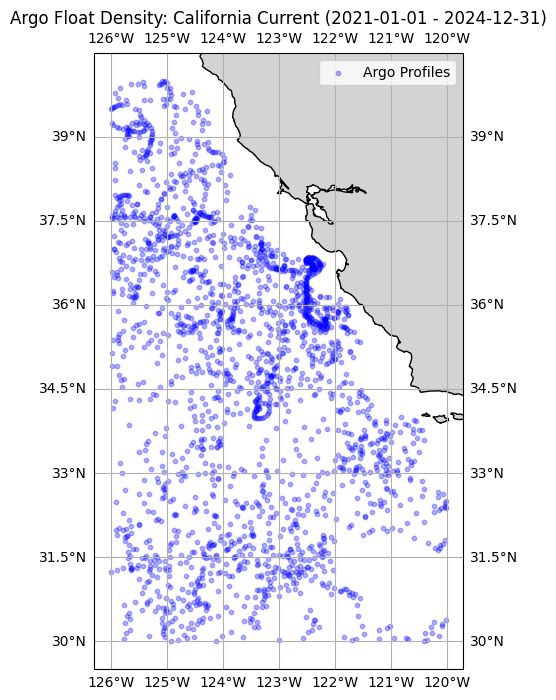

🗺️ Map generated. Check 'california_argo_scout.png'


In [5]:
# --- SECTION 3: VISUALIZATION (THE MAP) ---
if index_df is not None:
    fig = plt.figure(figsize=(10, 8))
    
    # Use PlateCarree projection (standard lat/lon)
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add land features so we can see the coast
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    
    # Plot the profiles
    # We use 'alpha=0.3' to make points semi-transparent. 
    # Darker areas = More data (Good for statistics!)
    sc = ax.scatter(index_df['longitude'], index_df['latitude'], 
                    s=10, c='blue', alpha=0.3, transform=ccrs.PlateCarree(),
                    label='Argo Profiles')
    
    # Formatting
    ax.set_title(f"Argo Float Density: California Current ({start_date} - {end_date})")
    ax.gridlines(draw_labels=True)
    plt.legend()
    
    # Save the map to check it
    plt.savefig('california_argo_scout.png')
    plt.show()
    
    print("🗺️ Map generated. Check 'california_argo_scout.png'")

In [6]:
# Quick Check: How many unique floats?
# Argo floats have unique WMO IDs.
unique_floats = index_df['wmo'].nunique()
print(f"🤖 Total unique floats found: {unique_floats}")

if unique_floats < 5:
    print("⚠️ Warning: Low float count. We might need to expand the box slightly offshore.")
else:
    print("🚀 Status: Good data density for analysis.")

🤖 Total unique floats found: 31
🚀 Status: Good data density for analysis.
